In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import animation


from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from scipy.linalg import block_diag
from filterpy.stats import plot_covariance_ellipse
from filterpy.common import Saver

In [2]:
const_acceleration_x = 2
const_acceleration_y = 1
dt=0.001
t= np.arange(0, 1.01, dt)
N = len(t)
traj = (2*(t**5)- 1.5*(t**4) + 0.05*(t**3) - 3*(t**2)+3*t)

t= (t)*100
traj= (traj)*100

### Utils Function

In [3]:
def get_x_y_velocities(t,x, dt):
  
    x_velocities = np.zeros(len(t))
    y_velocities = np.zeros(len(t))
    np.random.seed(25)
    sigma = 0.4
    mu = 0 
    
    for i in range(1,len(t)) :
        
        noise = np.random.normal(loc = mu, scale = sigma)
        
        x_velocities[i] = ( t[i] - (t[i-1]+ (1/2)*const_acceleration_x*dt**2)) + noise
        y_velocities[i] = ( x[i] - (x[i-1]+ (1/2)*const_acceleration_y*dt**2)) + noise
    
    return x_velocities, y_velocities


def plot_measurements(measurements,ax):
    
    x_moon, y_moon = measurements.x_pos[len(measurements.x_pos)-1],  measurements.y_pos[len(measurements.y_pos)-1]
    x_earth, y_earth = measurements.x_pos[0], measurements.y_pos[0]
    
    plt.figure(figsize=(13,10))
    ax.plot(measurements.x_pos, measurements.y_pos, ls = "--",c='black', label = "Target Trajectoy")
    
    ax.set_title("Target Trajectory", fontsize=15)
    earth = plt.Circle(( x_earth, y_earth), 3, color='blue', label = "Earth")
    moon  = plt.Circle((x_moon, y_moon ), 1.5, color='grey', label = "Moon")
    ax.add_patch(earth)
    ax.add_patch(moon)
    #moon = ax.gca().add_artist(moon)
    #earth = ax.gca().add_artist(earth)
    
    legend_earth = plt.Line2D([0], [0], ls='None', color="blue", marker='o')
    legend_moon = plt.Line2D([0], [0], ls='None', color="grey", marker='o')
    legend_trajectory = plt.Line2D([0], [0], ls='--', color="black")
    ax.legend([legend_earth, legend_moon, legend_trajectory],["Earth","Moon","Target_Trajectory"])


def plot_tracking(predictions, measurements):
    
   
    
    plt.figure(figsize=(13,10))
    

    for x,y in zip(predictions[:,0],predictions[:,1]):
        
        plt.clf()
        
        plot_measurements(measurements)
        
        spaceship_pred = plt.Circle(( x, y), 3, color='red', label = "predicted spaceship")
        plt.gca().add_artist(spaceship_pred)
        plt.show()
        


def init_kalman():
    
    #Transition_Matrix matrix
    PHI =   np.array([[1, 0, dt, 0, (dt**2)/2, 0],
                     [0, 1, 0, dt, 0, (dt**2)/2],
                     [0, 0, 1,  0, dt, 0,],
                     [0, 0, 0,  1, 0, dt],
                     [0, 0, 0,  0,  1 , 0],
                     [0, 0, 0,  0,  0 , 1] ])


    # Matrix Observation_Matrix
    #We are looking for the position of the spaceship
    H = np.array([[1,0,0,0,0,0],
                 [0,1,0,0,0,0]])


    #initial state
    init_states = np.array([measurements.x_pos[0], measurements.y_pos[0], 
                  measurements.x_vel[0], measurements.y_vel[0], const_acceleration_x, const_acceleration_y ])



    acc_noise = (0.01)**2;
    G = np.array([ [(dt**2)/2],
                    [(dt**2)/2],
                    [    dt   ],
                    [    dt   ],
                    [    1    ],
                    [    1    ]])

    Q = np.dot(G, G.T)*acc_noise
    
    return init_states, PHI, H, G, Q 

def Ship_tracker(dt):
    
    init_states, PHI, H, G, Q = init_kalman()
    
    tracker= KalmanFilter(dim_x = 6, dim_z=2)
    tracker.x = init_states

    tracker.F = PHI
    tracker.H = H   # Measurement function
    tracker.P = np.eye(6)*500   # covariance matrix
    tracker.R = np.eye(2)* 0.001  # state uncertainty
    q = Q_discrete_white_noise(2, dt=dt, var=15, block_size=3)
    tracker.Q =  q # process uncertainty
    
    return tracker


def run(tracker, zs):
    
    preds, cov = [],[]
    for z in zs:
        
        tracker.predict()
        tracker.update(z=z)
        
        preds.append(tracker.x)
        cov.append(tracker.P)
    
    return np.array(preds), np.array(cov)




class Animation:
    
    def __init__(self,predictions, measurements):
        
        self.predictions = predictions
        self.measurements= measurements
        self.fig =  plt.figure(figsize=(13,10))
        plt.axis([0,np.max(measurements.x_pos),0,np.max(measurements.y_pos)])
        self.ax = plt.gca()
        #plot_measurements(measurements,self.ax)
          
     
        
    def init(self):
        print(333)
        return []
    
    def animate(self,i):
        
        x_pred = predictions[:,0]
        y_pred = predictions[:,1]
        print('sssssss')
        patches = []
        
        for x,y in zip(x_pred, y_pred):
            print(x," ",y)
            patches.append( self.ax.add_patch( plt.Circle(( x , y), 3, color='r')) )
        
        return patches
    
    def run_animation(self):
        animation.FuncAnimation(fig=self.fig, func=self.animate, init_func=self.init)
        plt.show()
    



In [4]:
x_vel, y_vel = get_x_y_velocities(t, traj, dt)

measurements = pd.DataFrame()
measurements['x_pos']= t
measurements['y_pos']= traj
measurements['x_vel']= x_vel
measurements['y_vel']= y_vel

measurements.head(20)

,x_pos,y_pos,x_vel,y_vel
0,0.0,0.000000,0.000000,0.000000
1,0.1,0.299700,0.191308,0.391009
2,0.2,0.598800,0.510755,0.709856
3,0.3,0.897300,-0.235835,-0.037334
4,0.4,1.195200,-0.136474,0.061427
5,0.5,1.492501,-0.282756,-0.085456
6,0.6,1.789201,0.011069,0.207770
7,0.7,2.085301,-0.147967,0.048134
8,0.8,2.380802,0.835161,1.030662
9,0.9,2.675703,-0.721293,-0.526392


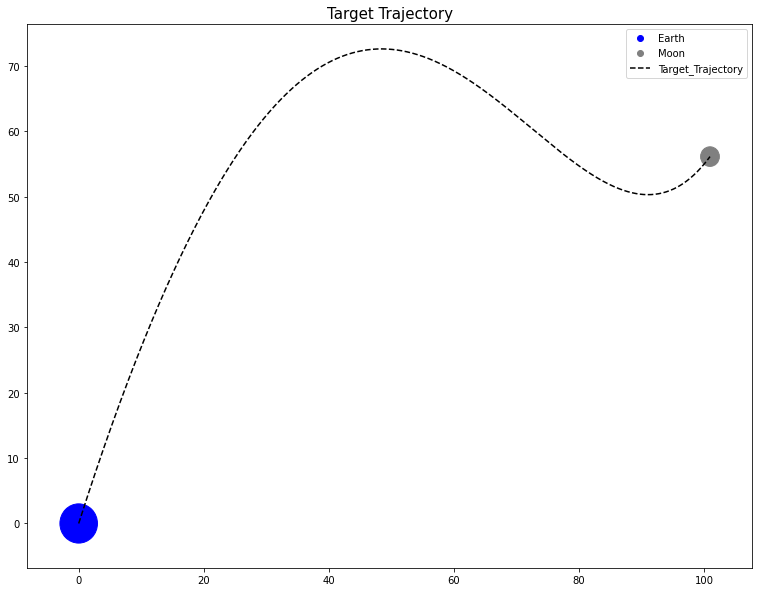

<Figure size 936x720 with 0 Axes>

In [5]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(1,1,1)
plot_measurements(measurements,ax)

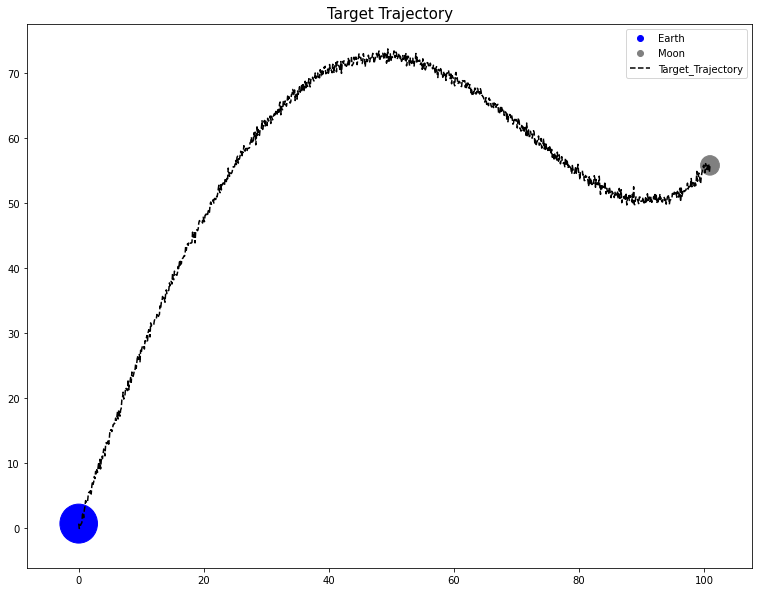

<Figure size 936x720 with 0 Axes>

In [6]:
sigma_pos = 0.5
mu_pos = 0

np.random.seed(24)

noise_t = np.random.normal(loc = mu_pos, scale = sigma_pos, size=N)

traj_noisy = traj+noise_t

measurements["y_pos"] = traj_noisy


fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(1,1,1)
plot_measurements(measurements,ax)

In [7]:
tracker = Ship_tracker(dt)
zs = measurements[["x_pos","y_pos"]].to_numpy()
print(zs[:5])
preds, cov = run(tracker, zs)

pd.DataFrame(preds).head()

[[ 0.          0.66460609]
 [ 0.1        -0.08531672]
 [ 0.2         0.44065986]
 [ 0.3         0.40189493]
 [ 0.4         0.65979215]]


,0,1,2,3,4,5
0,1.999994e-12,0.664606,0.002000,0.001000,2.000000,1.000000
1,6.000032e-02,0.212864,20.003922,-149.088942,2.030000,0.776364
2,1.500028e-01,0.284639,50.004408,-55.568184,2.099996,0.994654
3,2.571467e-01,0.328327,71.433345,-18.782897,2.178560,1.129498
4,3.666720e-01,0.497674,83.338684,39.303179,2.249977,1.477051


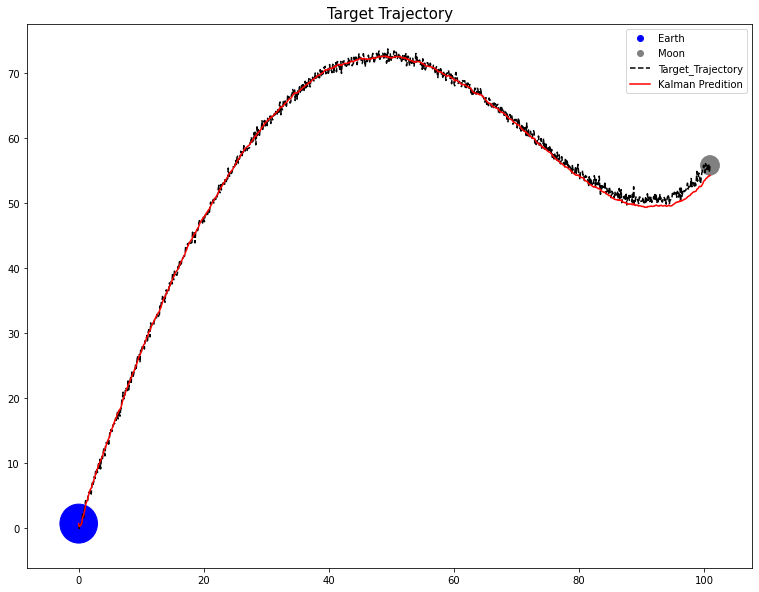

<Figure size 936x720 with 0 Axes>

In [8]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(1,1,1)
plot_measurements(measurements, ax)
ax.plot(preds[:,0], preds[:,1], c="r")

legend_earth = plt.Line2D([0], [0], ls='None', color="blue", marker='o')
legend_moon = plt.Line2D([0], [0], ls='None', color="grey", marker='o')
legend_trajectory = plt.Line2D([0], [0], ls='--', color="black")
legend_prediction = plt.Line2D([0], [0], color="r",)
ax.legend([legend_earth, legend_moon, legend_trajectory, legend_prediction],["Earth","Moon","Target_Trajectory","Kalman Predition"])

In [9]:
#plot_tracking(preds, measurements)

In [10]:
fig =  plt.figure(figsize=(13,10))
#plt.axes([0,np.max(measurements.x_pos),0,np.max(measurements.y_pos)])
#ax = plt.axis([0,np.max(measurements.x_pos),0,np.max(measurements.y_pos)])
#plot_measurements(measurements,self.ax)
patch = plt.Circle((3, 3), 3, fc='r')       
x_pred = preds[:,0]
y_pred = preds[:,1]
    
        
def init():
    patch.center=(5,5)
    ax.add_patch(patch)
    return patch,
    
def animate(i):
    print("sssss")
    x, y = x_pred[i], y_pred[i]
    patch.center(x,y)
    return patch,
        
anim= animation.FuncAnimation(fig=fig, func=animate, init_func=init,frames=len(x_pred),interval=50, blit=True)
    
plt.show()
    

<Figure size 936x720 with 0 Axes>